This is a simple experiment to attempt to break a Caesar cipher using Grover's algorithm. This notebook relies on code and ideas from https://colab.research.google.com/drive/1Hf32FpCb6wk3R3zRtUh7izDo-k5VZJsS?usp=sharing&s=09#scrollTo=ezSsiXKp4Kdx
and
https://eprint.iacr.org/2021/554.pdf.

In [ ]:
!python3 -m pip install -q qiskit numpy matplotlib pylatexenc qiskit-ibmq-provider qiskit-ibm-provider qiskit_ibm_runtime

In [ ]:
# importing required libraries
import matplotlib.pyplot as plt
import numpy as np

from math import floor, ceil
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_ibm_provider import IBMProvider
from qiskit.providers.ibmq import least_busy
from qiskit.circuit.library import MCMTVChain, CCZGate, GroverOperator

# import basic plot tools
from qiskit.visualization import plot_histogram

Let's first create the MAJ and UMA modules which are needed for the binary addition circuit.

In [ ]:
# First create the MAJ gate module
qregM = QuantumRegister(3)                     # create a generic quantum register with 3 qubits
MAJ_gate = QuantumCircuit(qregM)               # create a circuit using these quantum 3 qubits
MAJ_gate.cx(qregM[2], qregM[1])                # perform XOR on q2 and q1, store result in q1
MAJ_gate.cx(qregM[2], qregM[0])                # perform XOR on q2 and q0, store result in q0
MAJ_gate.ccx(qregM[0], qregM[1], qregM[2])    # perform Toffoli gate operation, store in q2

# Now create the UMA gate module
qregU = QuantumRegister(3)                    # create a generic quantum register with 3 qubits
UMA_gate = QuantumCircuit(qregU)              # create a circuit using these quantum 3 qubits
UMA_gate.ccx(qregU[0], qregU[1], qregU[2])    # perform Toffoli gate operation, store in q2
UMA_gate.cx(qregU[2], qregU[0])               # perform XOR on q2 and q0, store result in q0
UMA_gate.cx(qregU[0], qregU[1])               # perform XOR on q0 and q1, store result in q1

# Let'S take a look at our modules, can only do this before converting to gates
# MAJ_gate.draw(output='mpl')
# UMA_gate.draw(output='mpl')

# Convert them to gates to use them in our adder circuit
MAJ_gate = MAJ_gate.to_gate()
UMA_gate = UMA_gate.to_gate()

Now we can create the adder circuit module from the MAJ and UMA gates.

In [ ]:
# Create a 5-qubit adder circuit using the MAJ and UMA modules
# We need 5 for plaintext, 5 for key, 1 for first carry-in. We'll ignore the 1 for last sum qubit
n = 11
qregA = QuantumRegister(n)
adder = QuantumCircuit(qregA)

# Appending MAJ gates
for i in range(0, n-2, 2):
  adder.append(MAJ_gate, ([qregA[j] for j in range(i, i+3)]))

# We won't use the z qubit since we're doing modular addition:
# The largest we'll add is 25, so we won't have a final carry out.
# XOR on z qubit and a4, store in z qubit for the highest carry value
# adder.cx(qregA[n-2], qregA[n-1])

# Appending UMA gates
for i in range(n-1, 0, -2):
  adder.append(UMA_gate, ([qregA[j] for j in range(i-2, i+1)]))

# Let's take a look at the adder circuit
# adder.draw(output='mpl')

# Convert it to a gate to use it in the oracle
adder = adder.to_gate()

We need to build the inverse of the adder circuit now, by first creating an inverse of the UMA and MAJ modules. This subtractor will be used in the last part of the oracle.

In [ ]:
# First inverse the UMA gate
qregUi = QuantumRegister(3)                         # create a generic quantum register with 3 qubits
UMA_gate_inv = QuantumCircuit(qregUi)               # create a circuit using these quantum 3 qubits
UMA_gate_inv.cx(qregUi[0], qregUi[1])               # perform XOR on q0 and q1, store result in q1
UMA_gate_inv.cx(qregUi[2], qregUi[0])               # perform XOR on q2 and q0, store result in q0
UMA_gate_inv.ccx(qregUi[0], qregUi[1], qregUi[2])   # perform Toffoli gate operation, store in q2

# Let's take a look at the UMA inverse circuit
# UMA_gate_inv.draw(output='mpl')

# Now inverse the MAJ gate
qregMi = QuantumRegister(3)                         # create a generic quantum register with 3 qubits
MAJ_gate_inv = QuantumCircuit(qregMi)               # create a circuit using these quantum 3 qubits
MAJ_gate_inv.ccx(qregMi[0], qregMi[1], qregMi[2])   # perform Toffoli gate operation, store in q2
MAJ_gate_inv.cx(qregMi[2], qregMi[0])                 # perform XOR on q2 and q0, store result in q0
MAJ_gate_inv.cx(qregMi[2], qregMi[1])                 # perform XOR on q2 and q1, store result in q1

# Let's take a look at the MAJ inverse circuit
# MAJ_gate_inv.draw(output='mpl')

# Convert these 2 to gates and create the subtractor circuit
MAJ_gate_inv = MAJ_gate_inv.to_gate()
UMA_gate_inv = UMA_gate_inv.to_gate()

Let's build the subtractor module from our inversed gates.

In [ ]:
# Subtractor module

# Create a 5-qubit subtractor circuit using the MAJ_inverse and UMA_inverse modules
# We need 5 for plaintext, 5 for key, 1 for first borrow-in. We'll ignore the 1 for last borrow-out qubit
# We won't use the borrow-out qubit since we'll always subtract a bigger number from a smaller on
n = 11
qregS = QuantumRegister(n)
subtractor = QuantumCircuit(qregS)

# Appending UMA_inverse gates
for i in range(0, n-2, 2):
  subtractor.append(UMA_gate_inv, ([qregS[j] for j in range(i, i+3)]))

# Appending MAJ_inverse gates
for i in range(n-1, 0, -2):
  subtractor.append(MAJ_gate_inv, ([qregS[j] for j in range(i-2, i+1)]))

# Let's take a look at the adder circuit
# subtractor.draw(output='mpl')

# Convert it to a gate so we can use it in the oracle
subtractor = subtractor.to_gate()

Now we need to create the oracle based on the design from the paper referenced in the beginning.

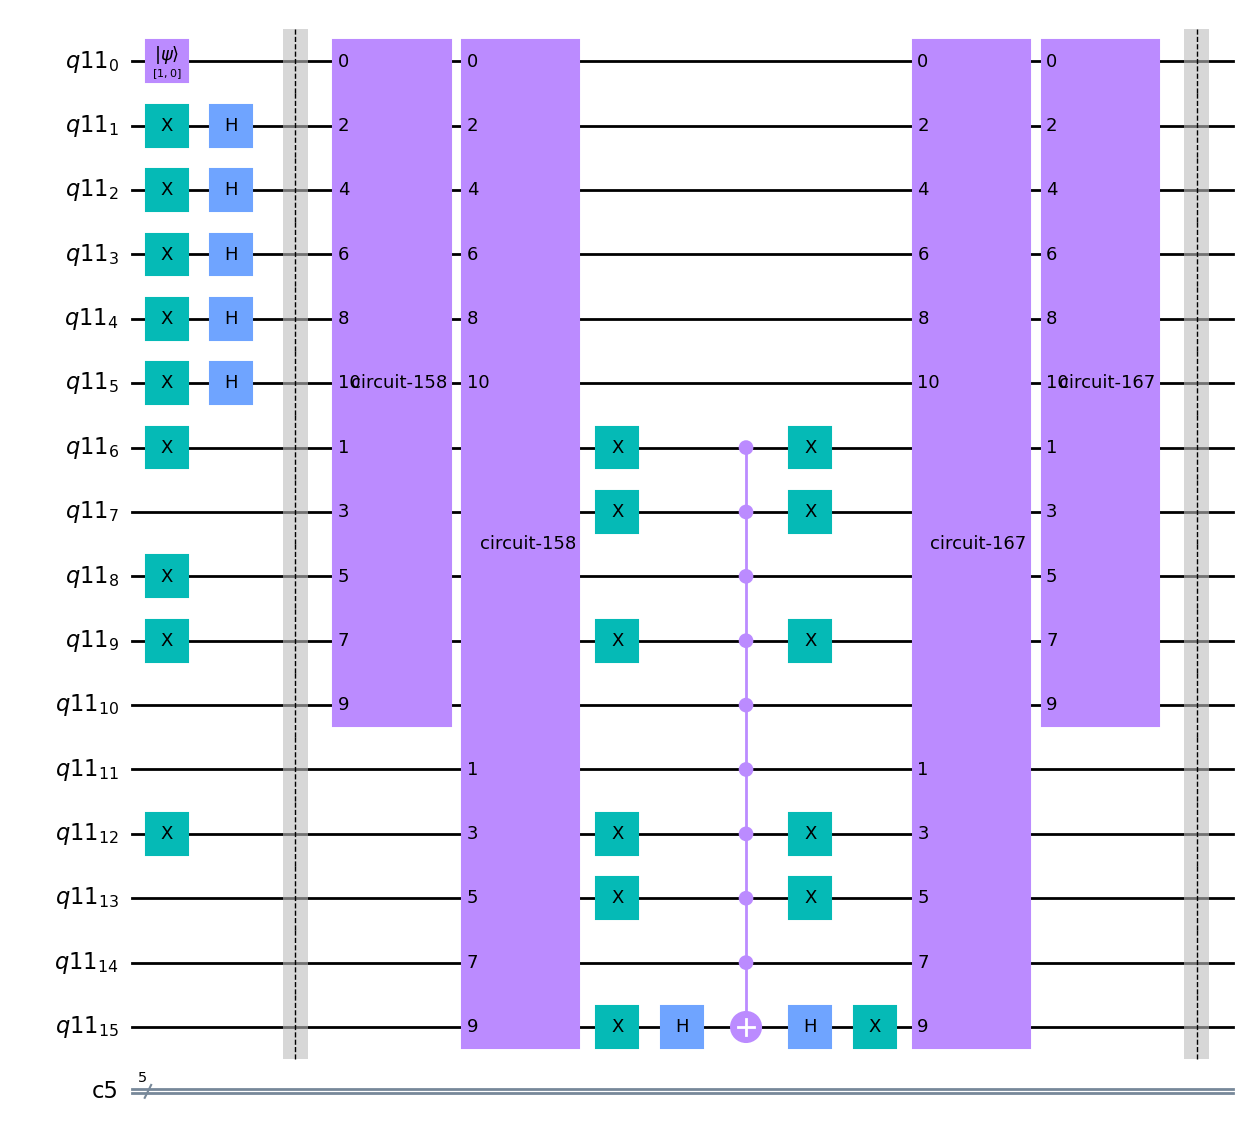

In [ ]:
# Plaintext bits
p1_bits = [0,1,1,0,1]    # 1st plaintext: letter M (13)
p2_bits = [0,0,0,1,0]    # 2nd plaintext: letter B (2)

# We supposedly don't know the key
# key_bits = [0,0,1,1,1]       # adds 7

# ciphertext bits
c1_bits = [1,0,1,0,0]   # letter T (20)
c2_bits = [0,1,0,0,1]   # letter I (9)

# Now let's build the oracle
# We'll need 5 qubits for key, 5 for plaintext, 5 for encrypted text, and 1 for initial carry in
n = 16
key_len = 5

# Crete registers for the oracle
qreg = QuantumRegister(n)

# Create registers for classical bits, we'll use those for the final key measurement
creg = ClassicalRegister(5)
grover = QuantumCircuit(qreg, creg)

# initialize the first qbit to 0 state, represented by the vector [1, 0]
grover.initialize([1,0], 0)

# Put the key qubits in superposition. Key bits: 1 - 5
for i in range(1, key_len+1):
    grover.x(qreg[i])
    grover.h(qreg[i])

# Now add X gates to the 1st plaintext where bit = 1. P bits: 6 - 10
for i in range(key_len+1, key_len*2):
  pos = key_len - i%6 -1    # must count in reverse
  if p1_bits[pos] == 1:
    grover.x(qreg[i])

# Add X gates to the 2nd plaintext where bit = 1. C bits: 11 - 15
for i in range((key_len*2)+1, key_len*3):
  pos = key_len - i%11 -1    # must count in reverse
  if p2_bits[pos] == 1:
    grover.x(qreg[i])

def add_oracle():
  # just to keep things neat
  grover.barrier()

  # Now encrypt 1st plaintext letter
  # qubit 0 is carry in, qubit 1-5 is key, qubit 6-10 is p1
  # we want to end up with [c0, p0, k0, p1, k1, p2, k2, p3, k3, p4, k4, p5, k5]
  # the sum, which is the ciphertext, ends up in the qubits of the plaintext
  adder_input = [qreg[i] for i in range(0,6)]
  pos = 1
  for i in range(6, 11):
    adder_input.insert(pos, qreg[i])
    pos += 2
  grover.append(adder, adder_input)

  # Now encrypt 2nd plaintext letter
  # qubit 0 is carry in, qubit 1-5 is key, qubit 11-15 is p2
  # we want to end up with [c0, p0, k0, p1, k1, p2, k2, p3, k3, p4, k4, p5, k5]
  adder_input = [qreg[i] for i in range(0,6)]
  pos = 1
  for i in range(11, 16):
    adder_input.insert(pos, qreg[i])
    pos += 2
  grover.append(adder, adder_input)

  # Now the phase-flip for the state in which plaintext matches ciphertext
  # Add X gates for the now encrypted plaintext where known ciphertext = 0
  # When the encrypted plaintext was 0, got turned to 1 by X gate.
  # So apply X gate where result is 0 to flip to 1 to match the ciphertext
  # Save indices for later
  inverted_c = []
  for i in range(6,11):
      pos = key_len - i%6 -1
      if c1_bits[pos] == 0:
        grover.x(qreg[i])
        inverted_c.append(i)

  for i in range(11, 16):
        pos = key_len - i%11 -1
        if c2_bits[pos] == 0:
          grover.x(qreg[i])
          inverted_c.append(i)

  # Now add the CCCCZ gate from qubit 6 to 15
  # Basic identity of single-qubit gates: Z = HXH
  # so we'll do this with a multi-controlled X gate sandwiched by H gates
  grover.h(qreg[n-1])
  grover.mcx([qreg[i] for i in range(key_len+1, n-1)], qreg[n-1])   # give the list of control qbits + target qbit
  grover.h(qreg[n-1])

  ################################################################################

  # At this point, the key has been marked i.e. its state has been reversed.
  # This allows the diffusion operator to know the good state (answer) of the key
  # Now, by design, Grover's algoritm works by iteration
  # So we need to restore the amplitudes and undo any computation to restore the state of the circuit
  # This means we will now decrypt what we encrypted, by inversing our add operation.

  # First flip back the ciphertext 1's that we inverted with X gates
  for i in inverted_c:
    grover.x(qreg[i])

  # Now dencrypt 2nd plaintext letter
  # qubit 0 is borrow-in, qubit 1-5 is key, qubit 11-15 is p2
  # we want to end up with [B0, p0, k0, p1, k1, p2, k2, p3, k3, p4, k4, p5, k5]
  subtract_input = [qreg[i] for i in range(0,6)]
  pos = 1
  for i in range(11, 16):
    subtract_input.insert(pos, qreg[i])
    pos += 2
  grover.append(subtractor, subtract_input)

  # Now decrypt 1st plaintext letter
  # qubit 0 is borrow-in, qubit 1-5 is key, qubit 6-10 is p1
  # we want to end up with [B0, p0, k0, p1, k1, p2, k2, p3, k3, p4, k4, p5, k5]
  # the difference, which is the original plaintext, ends up in the qubits of the plaintext
  subtract_input = [qreg[i] for i in range(0,6)]
  pos = 1
  for i in range(6, 11):
    subtract_input.insert(pos, qreg[i])
    pos += 2
  grover.append(subtractor, subtract_input)

  # just to keep things neat
  grover.barrier()

add_oracle()

# Take a look at the oracle
grover.draw(output='mpl')


Now we're done with the oracle. We need to next add the optimized diffusion operator

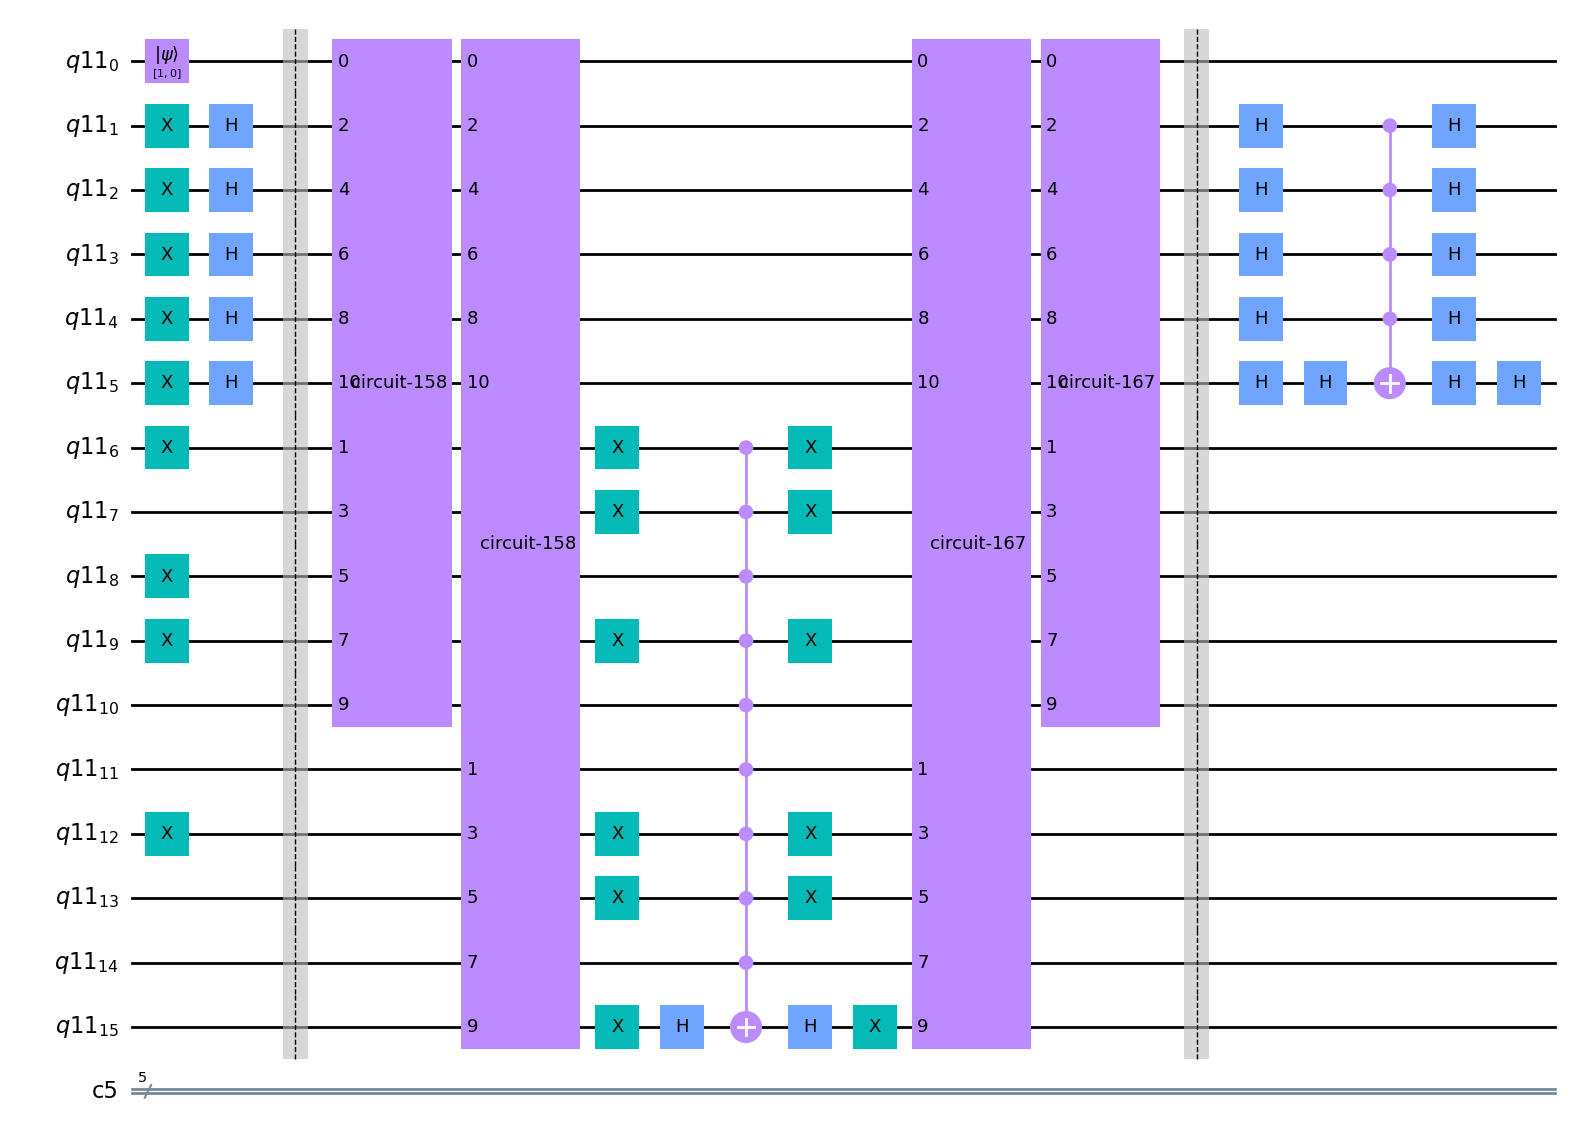

In [ ]:
def add_diffuser():
  # first let's Hadamard all the key qubits
  for i in range(1,key_len+1):
    grover.h(qreg[i])

  # Now we need a multi-controlled Z gate (CCCCZ gate) from qubit 1 to 5
  # Basic identity of single-qubit gates: Z = HXH
  # so we'll do this with a multi-controlled X gate sandwiched by H gates
  grover.h(qreg[key_len])
  grover.mcx([qreg[i] for i in range(1, key_len)], qreg[key_len])   # give the list of control qbits + target qbit
  grover.h(qreg[key_len])

  # Now Hadamard the key qbits again
  for i in range(1,key_len+1):
    grover.h(qreg[i])

# Tried using the GroverOperator to see what the diffusion operator will look like.
# from qiskit.circuit.library import GroverOperator
# grover_op = GroverOperator(grover, insert_barriers=True)
# grover_op.decompose().draw()
# We'll use the optimized diffuser instead.
# Note that we can probably remove the two H gates on either side of the mcx gate.
# But for now I'll keep them

add_diffuser()

# Take a look at the oracle
grover.draw(output='mpl')



Just want to see what the results would look like after each iteration.

Ideally, we'd do (pi/4) * sqrt(2^n) many iterations, where n is the length of our key. This means we need 4.44 iterations, so we'll do 3 more iterations.

In [ ]:
for i in range(3):
  add_oracle()
  add_diffuser()

Now that the circuit has been setup, we need to measure the key qubits to see the results.

In [ ]:
grover.measure(grover.qubits[1:6], range(5)) # measure the five qubits for the key into the first four output classical bits
grover.draw(output='mpl')

Now to put things to action hopefully. We'll run this on the AER Qiskit simulator first.

In [ ]:
from qiskit import execute
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Sampler
import time

# Authenticate to the service
my_token=''
service = QiskitRuntimeService(channel="ibm_quantum", token=my_token)

# Select the IBM qasm_simulator
simulator = service.backend("ibmq_qasm_simulator")

# Measure elapsed time and run the circuit
start = time.time()
from qiskit.test.reference_circuits import ReferenceCircuits
backend = service.backend("ibmq_qasm_simulator")
#job = Sampler(backend).run(ReferenceCircuits.bell())
job = Sampler(backend).run(grover)
print(f"job id: {job.job_id()}")
results = job.result()
end = time.time()

# Print results
print(f"Elapsed time: {end-start} s")
print("Results: ", results)

job id: clsgpna70abqioe2vbf0
Elapsed time: 10.488134384155273 s
Results:  SamplerResult(quasi_dists=[{25: 0.00025, 18: 0.00025, 8: 0.00025, 22: 0.00025, 7: 0.99825, 24: 0.00025, 17: 0.0005}], metadata=[{'shots': 4000, 'circuit_metadata': {}}])


Run on an actual Quantum computer.

In [ ]:
# from qiskit import execute
# from qiskit_ibm_runtime import QiskitRuntimeService, Options, Sampler
# import time

# # Authenticate to the service
# my_token=''
# service = QiskitRuntimeService(channel="ibm_quantum", token=my_token)

# # Measure elapsed time and run the circuit
# start = time.time()
# backend = service.backend("ibm_brisbane")

# options = Options()
# options.resilience_level = 1
# # options.optimization_level = 3

# job = Sampler(backend=backend, options=options).run(grover)
# print(f"job id: {job.job_id()}")
# results = job.result()
# end = time.time()

# # Print results
# print(f"Elapsed time: {end-start} s")
# print("Results: ", results)

job id: cnwhc18syp80008gvb6g
Elapsed time: 1798.5541861057281 s
Results:  SamplerResult(quasi_dists=[{0: 0.029483051056702, 1: 0.026129192226984, 2: 0.02545212351076, 3: 0.025116719725245, 4: 0.019430347571129, 5: 0.021716909394186, 6: 0.026046081036786, 7: 0.027818579880258, 8: 0.027325666995371, 9: 0.022932295497396, 10: 0.02216910955108, 11: 0.025106053187038, 12: 0.029218463952667, 13: 0.02562297972628, 14: 0.028959683309864, 15: 0.021039728031925, 16: 0.031518560170311, 17: 0.032117381764727, 18: 0.038127210873149, 19: 0.039634546532921, 20: 0.04299090292602, 21: 0.041579651721196, 22: 0.038015060320435, 23: 0.041557099604088, 24: 0.04032501581637, 25: 0.033780866699814, 26: 0.0357533858569, 27: 0.040391540522013, 28: 0.032531581833467, 29: 0.039252132015349, 30: 0.032291376357066, 31: 0.036566702332502}], metadata=[{'shots': 4000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 4.192463026492194, 'readout_mitigation_time': 0.02975192479789257, 'warning': 'Optimization leve

Want to try a 2-qubit Grover experiment to see the result. Let's say we are searching for 110 in a 3-qubit setting.

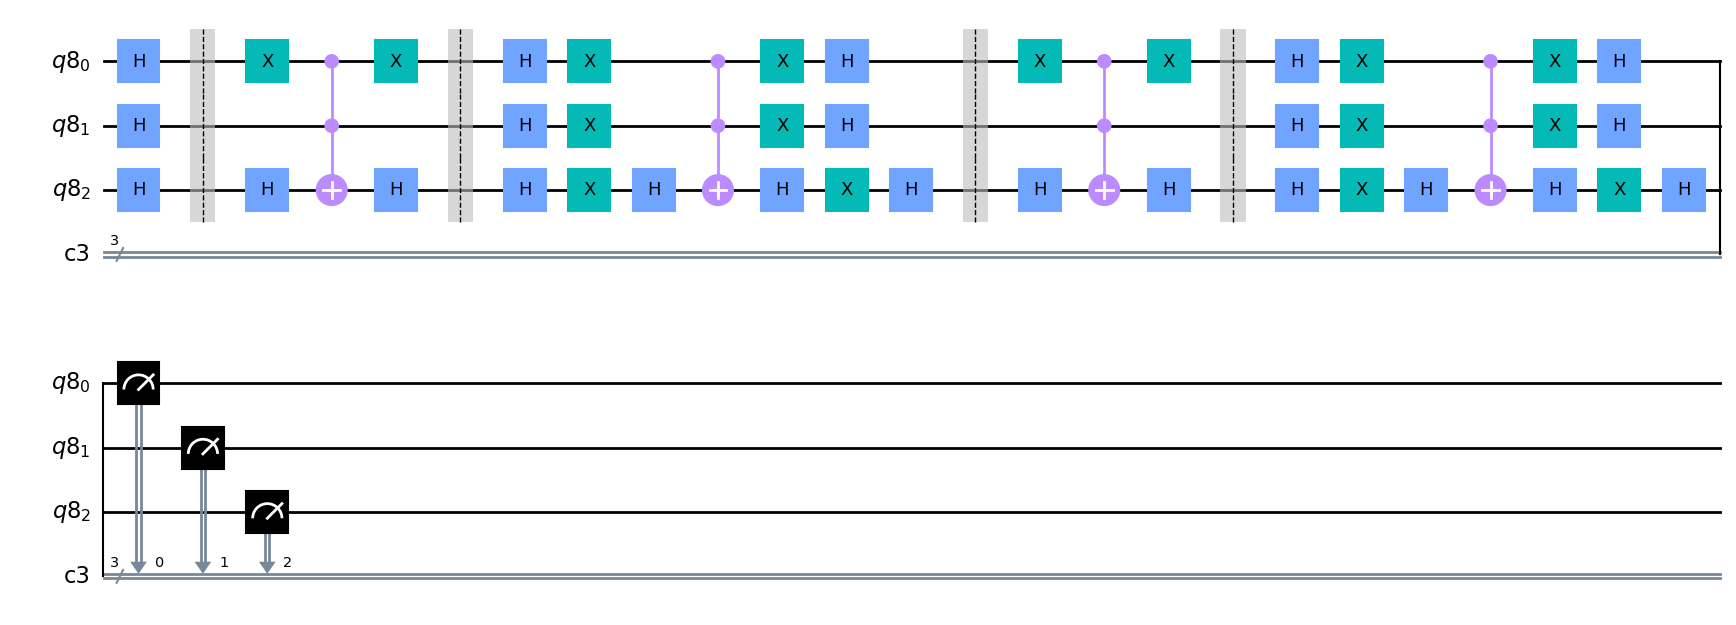

In [ ]:
n = 3
qr = QuantumRegister(n)
cr = ClassicalRegister(n)
simple_grover = QuantumCircuit(qr, cr)

# Add H gates to all our qubits
def add_H():
  for i in range(0, n):
    simple_grover.h(qr[i])

# Add X gates to all our qubits
def add_X():
  for i in range(0, n):
    simple_grover.x(qr[i])

#state preparation
add_H()
simple_grover.barrier()

def add_simple_oracle():
  # oracle function, just flip the 110 state then restore/inverse
  # add an X gate where the input is 0 so that it could get flipped when we apply the oracle
  simple_grover.x(qr[0])
  simple_grover.h(qr[2])
  simple_grover.mcx([qr[i] for i in range(0, 2)], qr[2])   # give the list of control qbits + target qbit
  simple_grover.h(qr[2])
  simple_grover.x(qr[0])    # inverse


# now the diffuser: CCZ gate from qubit 0 to 3
# Basic identity of single-qubit gates: Z = HXH
def add_simple_diffuser():
  add_H()
  add_X()
  simple_grover.h(qr[2])
  simple_grover.mcx([qr[i] for i in range(0, 2)], qr[2])   # give the list of control qbits + target qbit
  simple_grover.h(qr[2])
  add_X()
  add_H()

# First iteration
add_simple_oracle()
simple_grover.barrier()
add_simple_diffuser()
simple_grover.barrier()

# Second iteration
add_simple_oracle()
simple_grover.barrier()
add_simple_diffuser()

# Now measurements
simple_grover.measure(qr[0:3], range(3)) # measure the five qubits for the key into the first four output classical bits
simple_grover.draw(output="mpl")

In [ ]:
from qiskit import execute
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Sampler
import time

# Authenticate to the service
my_token=''
service = QiskitRuntimeService(channel="ibm_quantum", token=my_token)

# Measure elapsed time and run the circuit
start = time.time()
from qiskit.test.reference_circuits import ReferenceCircuits

#backend = service.backend("ibmq_qasm_simulator")
#backend = service.backend("ibm_osaka")

job = Sampler(backend).run(simple_grover)
print(f"job id: {job.job_id()}")
results = job.result()
end = time.time()

# Print results
print(f"Elapsed time: {end-start} s")
print("Results: ", results)

job id: cnwyqzq5vh500087ys0g
Elapsed time: 44.40247201919556 s
Results:  SamplerResult(quasi_dists=[{0: 0.032273122616955, 1: 0.034792301465683, 2: 0.056836066701385, 3: 0.030176260510462, 4: 0.048078748646713, 5: 0.051089347550256, 6: 0.702399311173403, 7: 0.044354841335144}], metadata=[{'shots': 4000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.1264499664977945, 'readout_mitigation_time': 0.021638073958456516, 'warning': 'Optimization level clipped from 3 to 1'}])
